## Physiological based pharmacokinetics that helps in visualizing liver and gut blood flow and drug metabolization

In [114]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


def pbpk_model(y, t, kabs, kmet, Vgut, Vliver, CL):
    Cgut, Cliver = y

    dCgut_dt = -kabs * Cgut
    dCliver_dt = kabs * Cgut / Vgut - (kmet * Cliver / Vliver) - (CL * Cliver / Vliver)

    return [dCgut_dt, dCliver_dt]

In [115]:
# # Define the PBPK parameters
# kabs = 0.2 # Absorption rate constant (1/h)
# kmet = 0.1 # Metabolism rate constant (1/h)
# Vgut = 1.0 # Gut volume (L)
# Vliver = 0.5 # Liver volume (L)
# CL = 0.05 # Liver clearance rate (L/h)

def model_plot_output(kabs = 0.2, kmet = 0.1, Vgut = 1, Vliver = 0.5, CL = 0.05,Cgut0 = 10, Cliver0 = 0):
    y0 = [Cgut0, Cliver0]
    t = np.linspace(0, 24, 20) # Timepoints in hours

    sol = odeint(pbpk_model, y0, t, args=(kabs, kmet, Vgut, Vliver, CL))

    Cgut = sol[:, 0]
    Cliver = sol[:, 1]
    AUC = np.trapz(Cliver, t)

    print(f'AUC = {AUC:.2f} mg*h/L')
    plt.plot(t, Cgut, label='Gut')
    plt.plot(t, Cliver, label='Liver')
    plt.xlabel('Time (h)')
    plt.ylabel('Drug concentration (mg/L)')
    plt.legend()
    plt.show()

AUC = 48.65 mg*h/L


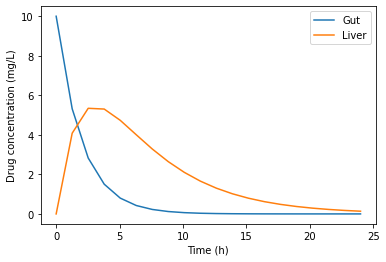

In [106]:
# Drug X

model_plot_output(kabs = 0.5, kmet = 0.05)

AUC = 7.87 mg*h/L


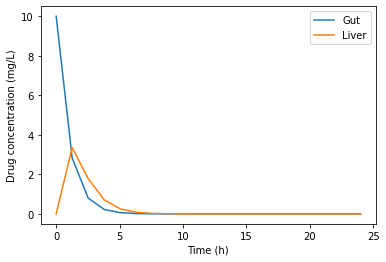

In [107]:
# Drug Y

model_plot_output(kabs = 1, kmet = 0.5)

AUC = 76.51 mg*h/L


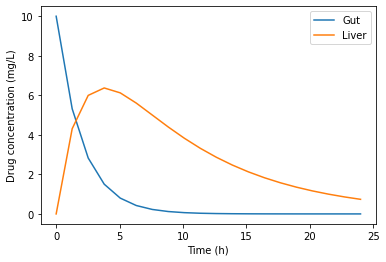

In [108]:
# Drug Z

model_plot_output(kabs = 0.5, kmet = 0.01, Vgut = 1, Vliver = 0.5, CL = 0.05,Cgut0 = 10, Cliver0 = 0)

## PK - PD modelling to show the relationship between PK and PD response

In [109]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize

def pk_model(y, t, ka, kel):
    Cp, Ce = y
    dCpdt = -ka * Cp
    dCedt = ka * Cp - kel * Ce
    return [dCpdt, dCedt]

def pd_model(y, t, Emax, EC50, gamma):
    Ce = y
    E = Emax * Ce**gamma / (EC50**gamma + Ce**gamma)
    return E

def objective(params, t, Cp_obs, E_obs):
    ka, kel, Emax, EC50, gamma = params
    y0 = [Cp_obs[0], E_obs[0]]
    y = odeint(pk_model, y0, t, args=(ka, kel))
    Ce = y[:, 1]
    E_pred = pd_model(Ce, t, Emax, EC50, gamma)
    return np.sum((E_pred - E_obs)**2)

EC50 = 6.99822840019884


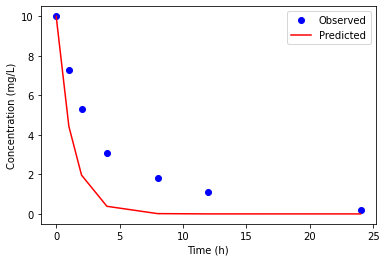

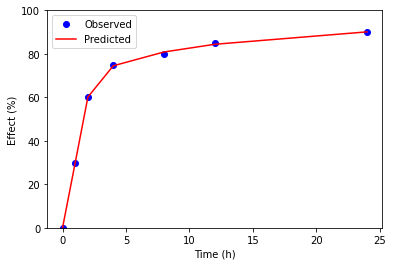

In [116]:
#Drug X
def pkpd_model_plot_output(t = np.array([0, 1, 2, 4, 8, 12, 24]),Cp_obs = np.array([10, 7.3, 5.3, 3.1, 1.8, 1.1, 0.2]),
                          E_obs = np.array([0, 30, 60, 75, 80, 85, 90]),params0 = [1, 0.1, 100, 2, 1]):
    res = minimize(objective, params0, args=(t, Cp_obs, E_obs), method='Nelder-Mead')
    ka, kel, Emax, EC50, gamma = res.x
    print(f"EC50 = {EC50}")

    y0 = [Cp_obs[0], E_obs[0]]
    y = odeint(pk_model, y0, t, args=(ka, kel))
    Ce = y[:, 1]
    E_pred = pd_model(Ce, t, Emax, EC50, gamma)

    import matplotlib.pyplot as plt

    fig, ax = plt.subplots()
    ax.plot(t, Cp_obs, 'bo', label='Observed')
    ax.plot(t, y[:, 0], 'r-', label='Predicted')
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Concentration (mg/L)')
    ax.legend()
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(t, E_obs, 'bo', label='Observed')
    ax.plot(t, E_pred, 'r-', label='Predicted')
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Effect (%)')
    ax.set_ylim(0,100)
    ax.legend()
    plt.show()
pkpd_model_plot_output()

EC50 = 15.937021967501401


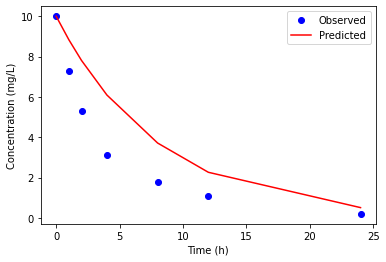

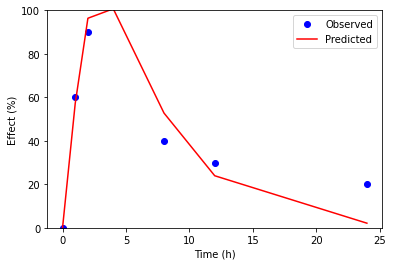

In [117]:
# Drug Y
pkpd_model_plot_output(t = np.array([0, 1, 2, 4, 8, 12, 24]),Cp_obs = np.array([10, 7.3, 5.3, 3.1, 1.8, 1.1, 0.2]),
                          E_obs = np.array([0, 60, 90, 110,40 , 30, 20]),params0 = [1, 0.1, 100, 2, 1])

EC50 = 8.085651513515447


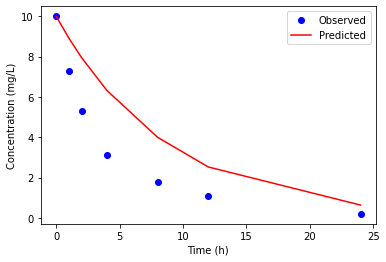

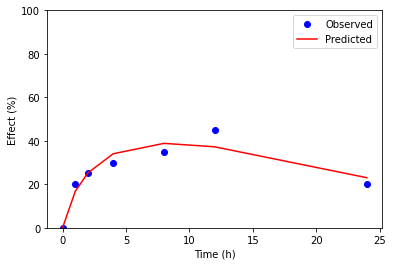

In [112]:
# Drug Z
pkpd_model_plot_output(t = np.array([0, 1, 2, 4, 8, 12, 24]),Cp_obs = np.array([10, 7.3, 5.3, 3.1, 1.8, 1.1, 0.2]),
                          E_obs = np.array([0, 20, 25, 30,35 , 45, 20]),params0 = [1, 0.1, 100, 2, 1])

In [113]:
#ends here